# Convolutional Network Benchmark

To obtain a benchmark for a basic convolutional network, we will create a simple network that informs us what to expect when using these networks. This will not contain any novel specializations, it is done to find a baseline which we can improve upon.

The architecture used here is inspired by the research in the form of the paper ['A Sensitivity Analysis of (and Practitioners’ Guide to) Convolutional Neural Networks for Sentence Classification'](https://arxiv.org/pdf/1510.03820.pdf), and is not complex.

While previous experiments have been done to find applicability of convolutional networks, this is the first to run it over a large set of data.

In [1]:
from exp8_feature_extraction import get_balanced_dataset
from scripts.cross_validate import run_cross_validate
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.activations import relu, sigmoid

import matplotlib.pyplot as plt
import numpy as np
import gensim
import json
import pickle
from seaborn import boxplot
from pandas import DataFrame

import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [268]:
def _decode_record(record):
    example = tf.parse_single_example(record, {
        'feature': tf.FixedLenFeature([300*150], tf.float32),
        'label': tf.FixedLenFeature([2], tf.int64),
    })
    example['feature'] = tf.reshape(example['feature'], [150, 300, 1])
    return example['feature'], example['label']

In [269]:
ds = (tf.data.TFRecordDataset('tmp.tfrecord').repeat(100).shuffle(buffer_size=100).map(_decode_record).make_one_shot_iterator().get_next())

Decoding record  Tensor("ParseSingleExample/ParseSingleExample:1", shape=(2,), dtype=int64)


In [270]:
sess = tf.keras.backend.get_session()
iterator = tf.data.TFRecordDataset('tmp.tfrecord').map(_decode_record).make_one_shot_iterator()
review_vecs = []
count = 16000
counta = 0
countb = 0
try:
    nxt = iterator.get_next()
    while True:
        #review_vecs.append(sess.run(nxt['feature']))
        val = sess.run(nxt[1])
        if val[1] == 1:
            countb += 1
        elif val[0] == 1:
            counta += 1
        count -= 1
        if count <= 0:
            break
except tf.errors.OutOfRangeError:
    pass
print(counta, countb)

Decoding record  Tensor("ParseSingleExample/ParseSingleExample:1", shape=(2,), dtype=int64)
52 50


In [206]:
assert np.array_equal(training_vectors[:1000], review_vecs)

In [274]:
read_dataset = tf.data.TFRecordDataset('tmp.tfrecord').map(_decode_record).shuffle(buffer_size=100).repeat(100).batch(6299)

Decoding record  Tensor("ParseSingleExample/ParseSingleExample:1", shape=(2,), dtype=int64)


In [246]:
iterator = read_dataset.make_one_shot_iterator()
inputs = iterator.get_next()

In [247]:
iterator, inputs

(<tensorflow.python.data.ops.iterator_ops.Iterator at 0x7fbb4837e128>,
 (<tf.Tensor 'IteratorGetNext_1795:0' shape=(?, 150, 300, 1) dtype=float32>,
  <tf.Tensor 'IteratorGetNext_1795:1' shape=(?, 2) dtype=int32>))

In [275]:
conv_model = get_conv_wv_model()
conv_model.fit(read_dataset, steps_per_epoch=20, epochs=5)

Epoch 1/5
20/20 [==============================] - 170s 8s/step - loss: 0.6664 - acc: 0.5955
Epoch 2/5
20/20 [==============================] - 166s 8s/step - loss: 0.6396 - acc: 0.6377
Epoch 3/5
20/20 [==============================] - 165s 8s/step - loss: 0.6268 - acc: 0.6542
Epoch 4/5
20/20 [==============================] - 165s 8s/step - loss: 0.6188 - acc: 0.6626
Epoch 5/5
20/20 [==============================] - 166s 8s/step - loss: 0.6112 - acc: 0.6709


In [65]:
def embedded_word_feature(embedded_word):
    feature_list = tf.train.Feature(float_list=tf.train.FloatList(value=embedded_word))
    features = { "features": feature_list}
    return tf.train.Features(feature=feature_list).SerializeToString()

In [95]:
def serialize_example(*embedded_values):
  print(embedded_values)
  tf_string = tf.py_func(
      embedded_word_feature,
      (embedded_values),
      tf.string)
  return tf.reshape(tf_string, ())

In [244]:
def get_conv_wv_model():
  model = Sequential([
      Conv2D(
          filters=50,
          kernel_size=(10, 300),
          data_format="channels_last",
          input_shape=(max_review_words, 300, 1),
          activation=relu),
      tf.keras.layers.GlobalMaxPooling2D(data_format="channels_last"),
      Dropout(0.5),
      Flatten(),
      Dense(2, activation='softmax')
  ])
  model.compile(
      loss='binary_crossentropy',
      optimizer='adam',
      metrics=['accuracy'])
  return model

In [16]:
len(training_vectors)

125980

In [17]:
from tensorflow.keras.utils import to_categorical
categorical_labels = to_categorical(training_labels)

In [18]:
vectors_placeholder = tf.placeholder(training_vectors.dtype, training_vectors.shape)
labels_placeholder = tf.placeholder(categorical_labels.dtype, categorical_labels.shape)

In [19]:
dataset = tf.data.Dataset.from_tensor_slices((vectors_placeholder, labels_placeholder)).repeat(5).batch(6299)

In [20]:
iterator = dataset.make_initializable_iterator()

In [21]:
sess = tf.keras.backend.get_session()
sess.run(iterator.initializer,
         feed_dict={vectors_placeholder: training_vectors, labels_placeholder: categorical_labels})

In [23]:
conv_model = get_conv_wv_model()
conv_model.fit(iterator, steps_per_epoch=20, epochs=5)

Epoch 1/5
20/20 [==============================] - 169s 8s/step - loss: 0.6660 - acc: 0.5961
Epoch 2/5
20/20 [==============================] - 169s 8s/step - loss: 0.6401 - acc: 0.6382
Epoch 3/5
20/20 [==============================] - 169s 8s/step - loss: 0.6279 - acc: 0.6533
Epoch 4/5
20/20 [==============================] - 169s 8s/step - loss: 0.6192 - acc: 0.6626
Epoch 5/5
11/20 [===============>..............] - ETA: 1:15 - loss: 0.6142 - acc: 0.6675WARNING:tensorflow:Your dataset iterator ran out of data; interrupting training. Make sure that your dataset can generate at least `steps_per_epoch * epochs` batches (in this case, 20 batches). You may need touse the repeat() function when building your dataset.Your dataset iterator ran out of data; interrupting training. Make sure that your dataset can generate at least `steps_per_epoch * epochs` batches (in this case, 20 batches). You may need touse the repeat() function when building your dataset.Your dataset iterator ran out of d

In [ ]:
conv_wv_scores = run_cross_validate(get_conv_wv_model, training_vectors, training_labels, cv=6, categorical=True)

In [29]:
print(conv_wv_scores)
print("Average accuracy:", sum(conv_wv_scores['accuracies'])/len(conv_wv_scores['accuracies']))

{'accuracies': [0.66613211939372, 0.6612177331746935, 0.6639077130029282, 0.6568368772311035, 0.654612240674634, 0.6592684567230587]}
Average accuracy: 0.6603291900333562


Convolutional networks perform significantly better than FFNNs and the results are not widely varying. This appears to be a confident benchmark for a simple convolutional network.

The distribution of results is as follows:

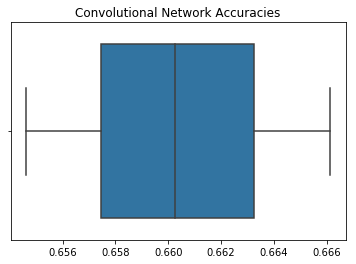

In [3]:
boxplot(DataFrame(conv_wv_scores)).set_title("Convolutional Network Accuracies")

plt.show()

Now let's try the model on unseen data:

In [26]:
from tensorflow.keras.callbacks import EarlyStopping
conv_model = get_conv_wv_model()
conv_model.fit(training_vectors, to_categorical(training_labels), epochs=12, batch_size=128, validation_split=0.3,
               callbacks=[EarlyStopping(monitor='val_loss', patience=3)])

Train on 81186 samples, validate on 34794 samples
Epoch 1/12
81186/81186 [==============================] - 137s 2ms/step - loss: 0.6485 - acc: 0.6256 - val_loss: 0.6260 - val_acc: 0.6526
Epoch 2/12
81186/81186 [==============================] - 136s 2ms/step - loss: 0.6242 - acc: 0.6541 - val_loss: 0.6272 - val_acc: 0.6517
Epoch 3/12
81186/81186 [==============================] - 136s 2ms/step - loss: 0.6081 - acc: 0.6727 - val_loss: 0.6189 - val_acc: 0.6581
Epoch 4/12
81186/81186 [==============================] - 135s 2ms/step - loss: 0.5940 - acc: 0.6828 - val_loss: 0.6121 - val_acc: 0.6670
Epoch 5/12
81186/81186 [==============================] - 136s 2ms/step - loss: 0.5795 - acc: 0.6974 - val_loss: 0.6121 - val_acc: 0.6675
Epoch 6/12
81186/81186 [==============================] - 136s 2ms/step - loss: 0.5644 - acc: 0.7110 - val_loss: 0.6200 - val_acc: 0.6597
Epoch 7/12
81186/81186 [==============================] - 136s 2ms/step - loss: 0.5502 - acc: 0.7193 - val_loss: 0.6173 - 

In [34]:
categorical_labels = to_categorical(held_labels)

In [35]:
conv_model.evaluate(held_vectors, categorical_labels)[1]

10000/10000 [==============================] - 6s 609us/step


0.6657

In [37]:
auc_metric = tf.metrics.auc(categorical_labels, conv_model.predict(held_vectors))

In [41]:
auc, update_op = auc_metric
with tf.Session() as sess:
    sess.run(tf.local_variables_initializer())
    print("tf auc: {}".format(sess.run([auc, update_op])))

tf auc: [9999999000.0, 0.72368735]


The model performs very similarly on the unseen data as the data used to create the model. There was not a lot of tweaking, so it is not unreasonable that this should occur. If this can be maintained then this model could do well with slight changes in the domain, something very easy to do with product and service reviews.